# MNIST - Plots

Generating plots for the paper.

In [40]:
from __future__ import absolute_import, division, print_function
import os, sys, pdb, pickle
from collections import OrderedDict
from multiprocessing import Process, Pool
from itertools import product
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Lambda, Activation
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.engine.topology import Layer
from keras import regularizers, activations
from keras import backend as K

from quantization_layers import *
from network_parameterization import *

#os.environ['CUDA_VISIBLE_DEVICES']=''

out_folder = 'sweeps'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

## Load the sweeps

In [41]:
all_sweeps = [
    out_folder + '/log-uniform-01000.p',
]
raw_nns = []
raw_vasq = []
raw_vasf = []
for i,sw_file in enumerate(all_sweeps):
    with open(sw_file, 'rb') as f:
        sw = pickle.load(f)
        raw_nns += sw[0]
        raw_vasf += list(np.array(sw[1])[:,0])
        raw_vasq += list(np.array(sw[1])[:,1])

## Generate the plots

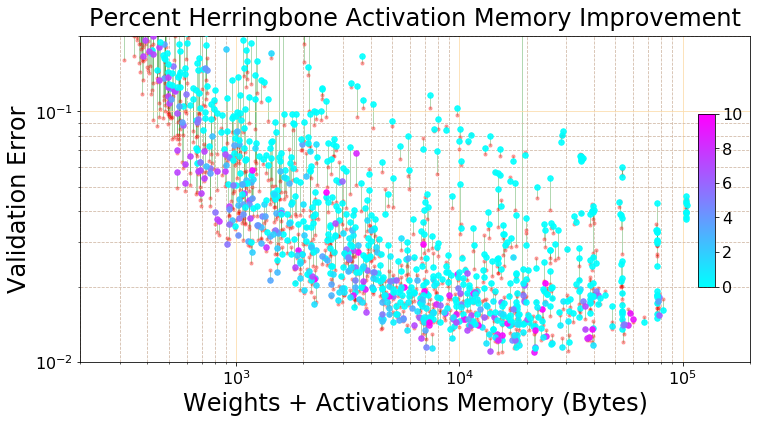

In [52]:
#use = 'Proportion Depthwise Separable Convolutions'
#use = 'Proportion Fully-Connected Layers'
#use = 'Proportion Increasing Channel Depth'
#use = 'Proportion 1x1 Kernels'
#use = 'Proportion 3x3 Kernels'
#use = 'Proportion 5x5 Kernels'
use = 'Percent Herringbone Activation Memory Improvement'
lims = mpl.colors.Normalize(vmin=0.0, vmax=10.0 if use == 'Percent Herringbone Activation Memory Improvement' else 1.0)

memf = []
memq = []
vasf = []
vasq = []
cmap = cm.cool
fig = plt.figure(figsize=(12,6))
for i in range(len(raw_nns)):
    nn = raw_nns[i]
    layer_types = [x[0] for x in nn]
    nlayer_C = len([x for x in layer_types if x == 'C'])
    nlayer_DSC = len([x for x in layer_types if x == 'DSC'])
    nlayer_F = len([x for x in layer_types if x == 'F'])
    kernels = [x[2] for x in nn if x[0] in ['C', 'CN', 'T', 'DSC']]
    nkern_1 = len([x for x in kernels if x == 1])
    nkern_3 = len([x for x in kernels if x == 3])
    nkern_5 = len([x for x in kernels if x == 5])
    channels = [1] + [x[1] for x in nn if x[0] in ['C', 'CN', 'T', 'DSC']]
    nchannels_inc = sum(np.diff(channels) > 0)
    
    w, a = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='herringbone')
    wn, an = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='normal')
    mem = w + a
    vef = 1-raw_vasf[i]
    veq = 1-raw_vasq[i]
    
    metrics = {
        'Proportion Depthwise Separable Convolutions':nlayer_DSC / (nlayer_C + nlayer_DSC),
        'Proportion Fully-Connected Layers':nlayer_F / (len(kernels) + nlayer_F),
        'Proportion Increasing Channel Depth':nchannels_inc / (len(channels) - 1),
        'Proportion 1x1 Kernels':nkern_1 / len(kernels),
        'Proportion 3x3 Kernels':nkern_3 / len(kernels),
        'Proportion 5x5 Kernels':nkern_5 / len(kernels),
        'Percent Herringbone Activation Memory Improvement':100*(1 - a/an),
    }
    plt.scatter(mem, vef, c='r', s=10, alpha=0.3, zorder=2, label='FP32')
    plt.scatter(mem, veq, c=cmap(lims(metrics[use])), s=30, alpha=0.9, zorder=3, label='Int4')
    plt.plot([mem, mem], [vef, veq], 'g-', linewidth=1, alpha=0.3, zorder=1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([200,2e5])
plt.ylim([1e-2,2e-1])
plt.title(use, fontsize=24, pad=10)
plt.ylabel('Validation Error', fontsize=24)
plt.xlabel('Weights + Activations Memory (Bytes)', fontsize=24)
plt.grid(b=True, which='major', color='#fcddab', linestyle='-')
plt.grid(b=True, which='minor', color='#d1baa7', linestyle='--')
cax = fig.add_axes([0.84,0.3,0.02,0.4])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=lims, orientation='vertical')
#cb.set_label(use)
plt.savefig('figures/%s.pdf'%use, bbox_inches='tight')
plt.show()

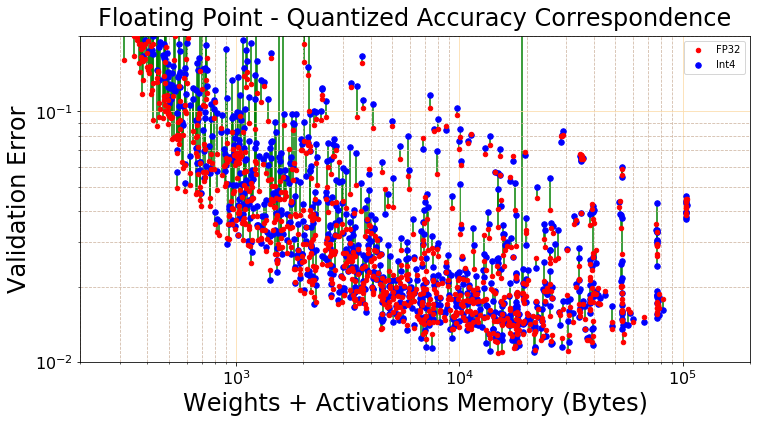

In [54]:
memf = []
memq = []
vasf = []
vasq = []
for i in range(len(raw_nns)):
    nn = raw_nns[i]
    w, a = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='herringbone')
    w2, a2 = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='naive')
    vaf = raw_vasf[i]
    vaq = raw_vasq[i]
    memf.append(w+a)
    vasf.append(1-vaf)
    memq.append(w+a)
    vasq.append(1-vaq)
plt.figure(figsize=(12,6))
plt.scatter(memf, vasf, c='r', s=20, zorder=3, label='FP32')
plt.scatter(memq, vasq, c='b', s=30, zorder=2, label='Int4')
for i in range(len(memf)):
    plt.plot([memf[i], memq[i]], [vasf[i], vasq[i]], 'g-', zorder=1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([200,2e5])
plt.ylim([1e-2,2e-1])
plt.title('Floating Point - Quantized Accuracy Correspondence', fontsize=24, pad=10)
plt.ylabel('Validation Error', fontsize=24)
plt.xlabel('Weights + Activations Memory (Bytes)', fontsize=24)
plt.grid(b=True, which='major', color='#fcddab', linestyle='-')
plt.grid(b=True, which='minor', color='#d1baa7', linestyle='--')
plt.legend()
plt.savefig('figures/pareto_float_quant.pdf', bbox_inches='tight')
plt.show()

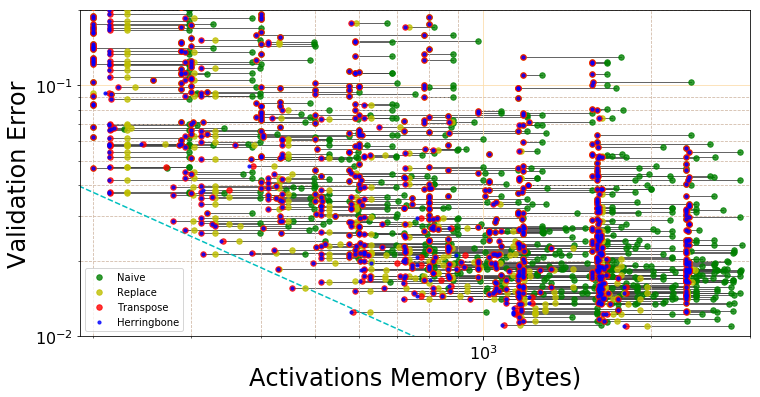

In [55]:
mn = []
mb = []
mt = []
mh = []
vas = []
for i in range(len(raw_nns)):
    nn = raw_nns[i]
    wn, an = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='naive', verbose=0)
    wb, ab = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='normal', verbose=0)
    wt, at = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='transpose', verbose=0)
    wh, ah = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='herringbone', verbose=0)
    if an > 3e3: continue
    vas.append(1-raw_vasq[i])
    mn.append(an)
    mb.append(ab)
    mt.append(at)
    mh.append(ah)
plt.figure(figsize=(12,6))
plt.scatter(mn, vas, c='g', s=30, alpha=0.8, zorder=2, label='Naive')
plt.scatter(mb, vas, c='y', s=30, alpha=0.8, zorder=3, label='Replace')
plt.scatter(mt, vas, c='r', s=30, alpha=0.8, zorder=4, label='Transpose')
plt.scatter(mh, vas, c='b', s=10, alpha=0.8, zorder=5, label='Herringbone')
pareto_mem = np.arange(100,1000)
pareto_err = 7.5 / pareto_mem
for i in range(len(mn)):
    plt.plot([mn[i], mh[i]], [vas[i], vas[i]], '#404040', linewidth=1, alpha=0.8, zorder=1)
plt.plot(pareto_mem, pareto_err, 'c--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Validation Error', fontsize=24)
plt.xlabel('Activations Memory (Bytes)', fontsize=24)
plt.grid(b=True, which='major', color='#fcddab', linestyle='-')
plt.grid(b=True, which='minor', color='#d1baa7', linestyle='--')
plt.legend(loc='lower left')
plt.xlim([190,3e3])
plt.ylim([1e-2,2e-1])
plt.savefig('figures/pareto_all.pdf', bbox_inches='tight')
plt.show()

## Analysis of Best Architecture

In [14]:
nn = [('A', 2, 4), ('C', 5, 3, 4, 8, 4), ('C', 8, 3, 4, 8, 4), ('C', 11, 3, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 8)]
wn, an = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='naive', verbose=0)
wb, ab = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='normal', verbose=0)
wt, at = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='transpose', verbose=0)
wh, ah = compute_storage(nn, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='herringbone', verbose=0)

import pandas as pd
from collections import OrderedDict
df = pd.DataFrame(OrderedDict([('Activations',[an,ab,at,ah]), ('Weights',[wn,wb,wt,wh]), ('Total',[wn+an,wb+ab,wt+at,wh+ah])]), index=['Naive', 'Baseline', 'Transpose', 'Herringbone'])
df

,Activations,Weights,Total
Naive,760.0,1512.5,2272.5
Baseline,467.5,1512.5,1980.0
Transpose,437.5,1512.5,1950.0
Herringbone,434.5,1512.5,1947.0


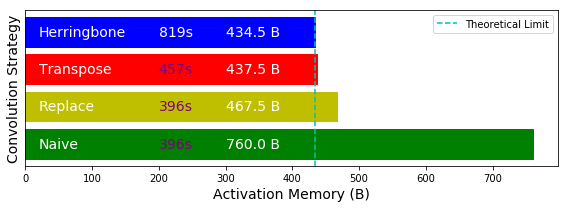

In [15]:
index = np.arange(4)
plt.figure(figsize=(8,3))
barlist = plt.barh(index, df['Activations'])
barlist[0].set_color('g')
barlist[1].set_color('y')
barlist[2].set_color('r')
barlist[3].set_color('b')
for i, lab in enumerate(['Naive', 'Replace', 'Transpose', 'Herringbone']):
    plt.text(s=lab, x=20, y=i, color='w', verticalalignment='center', size=14)
for i, val in enumerate(df['Activations']):
    plt.text(s=str(val)+' B', x=300, y=i, color='w', verticalalignment='center', size=14)
# Timing if using method on all convolutions in network.
for i, lab in enumerate(['396s', '396s', '457s', '819s']):
    plt.text(s=lab, x=200, y=i, color='w' if i == 3 else 'purple', verticalalignment='center', size=14)
# Timing if using method on only the critical memory-bound convolution(s) in network.
#for i, lab in enumerate(['396s', '396s', '487s', '684s']):
#    plt.text(s=lab, x=200, y=i, color='w' if i == 3 else 'purple', verticalalignment='center', size=14)
plt.axvline(x=ah, c='c', linestyle='--', label='Theoretical Limit')
plt.xlabel('Activation Memory (B)', fontsize=14)
plt.ylabel('Convolution Strategy', fontsize=14)
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig('figures/act-vs-strat.pdf')
plt.show()

## Comparison to Other Works

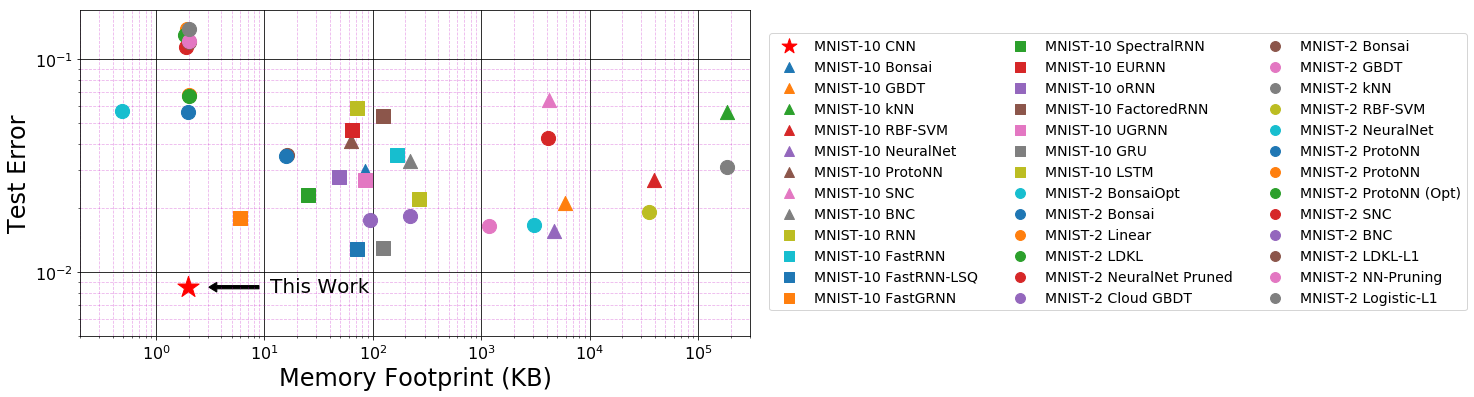

In [39]:
plt.figure(figsize=(24,6))
plot1 = plt.subplot(111)
plt.scatter([1.96],     [1-.9915], marker='*', s=500, zorder=10, color='r', label='MNIST-10 CNN')
plt.scatter([84.0],     [1-.9701], marker='^', s=200, zorder=10, label='MNIST-10 Bonsai')
plt.scatter([5859.0],   [1-.9790], marker='^', s=200, zorder=10, label='MNIST-10 GBDT')
plt.scatter([183984.0], [1-.9434], marker='^', s=200, zorder=10, label='MNIST-10 kNN')
plt.scatter([39084.0],  [1-.9730], marker='^', s=200, zorder=10, label='MNIST-10 RBF-SVM')
plt.scatter([4652.0],   [1-.9844], marker='^', s=200, zorder=10, label='MNIST-10 NeuralNet')
plt.scatter([63.4],     [1-.9588], marker='^', s=200, zorder=10, label='MNIST-10 ProtoNN')
plt.scatter([4172.0],   [1-.9360], marker='^', s=200, zorder=10, label='MNIST-10 SNC')
plt.scatter([220.46],   [1-.9668], marker='^', s=200, zorder=10, label='MNIST-10 BNC')

plt.scatter([71.0],     [1-.9410], marker='s', s=200, zorder=10, label='MNIST-10 RNN')
plt.scatter([166.0],    [1-.9644], marker='s', s=200, zorder=10, label='MNIST-10 FastRNN')
plt.scatter([71.0],     [1-.9872], marker='s', s=200, zorder=10, label='MNIST-10 FastRNN-LSQ')
plt.scatter([6.0],      [1-.9820], marker='s', s=200, zorder=10, label='MNIST-10 FastGRNN')
plt.scatter([25.0],     [1-.9770], marker='s', s=200, zorder=10, label='MNIST-10 SpectralRNN')
plt.scatter([64.0],     [1-.9538], marker='s', s=200, zorder=10, label='MNIST-10 EURNN')
plt.scatter([49.0],     [1-.9720], marker='s', s=200, zorder=10, label='MNIST-10 oRNN')
plt.scatter([125.0],    [1-.9460], marker='s', s=200, zorder=10, label='MNIST-10 FactoredRNN')
plt.scatter([84.0],     [1-.9729], marker='s', s=200, zorder=10, label='MNIST-10 UGRNN')
plt.scatter([123.0],    [1-.9870], marker='s', s=200, zorder=10, label='MNIST-10 GRU')
plt.scatter([265.0],    [1-.9780], marker='s', s=200, zorder=10, label='MNIST-10 LSTM')

plt.scatter([0.49],     [1-.9428], marker='o', s=200, zorder=10, label='MNIST-2 BonsaiOpt')
plt.scatter([1.96],     [1-.9438], marker='o', s=200, zorder=10, label='MNIST-2 Bonsai')
plt.scatter([1.93],     [1-.8616], marker='o', s=200, zorder=10, label='MNIST-2 Linear')
plt.scatter([1.87],     [1-.8701], marker='o', s=200, zorder=10, label='MNIST-2 LDKL')
plt.scatter([1.90],     [1-.8865], marker='o', s=200, zorder=10, label='MNIST-2 NeuralNet Pruned')
plt.scatter([93.75],    [1-.9824], marker='o', s=200, zorder=10, label='MNIST-2 Cloud GBDT')
plt.scatter([16.0],     [1-.9647], marker='o', s=200, zorder=10, label='MNIST-2 Bonsai')
plt.scatter([1172.0],   [1-.9836], marker='o', s=200, zorder=10, label='MNIST-2 GBDT')
plt.scatter([183750.0], [1-.9690], marker='o', s=200, zorder=10, label='MNIST-2 kNN')
plt.scatter([35159.0],  [1-.9808], marker='o', s=200, zorder=10, label='MNIST-2 RBF-SVM')
plt.scatter([3070.0],   [1-.9833], marker='o', s=200, zorder=10, label='MNIST-2 NeuralNet')
plt.scatter([15.96],    [1-.9650], marker='o', s=200, zorder=10, label='MNIST-2 ProtoNN')
plt.scatter([2.0],      [1-.9325], marker='o', s=200, zorder=10, label='MNIST-2 ProtoNN')
plt.scatter([2.0],      [1-.9329], marker='o', s=200, zorder=10, label='MNIST-2 ProtoNN (Opt)')
plt.scatter([4153.6],   [1-.9574], marker='o', s=200, zorder=10, label='MNIST-2 SNC')
plt.scatter([221.35],   [1-.9816], marker='o', s=200, zorder=10, label='MNIST-2 BNC')
plt.scatter([2.0],      [1-.8793], marker='o', s=200, zorder=10, label='MNIST-2 LDKL-L1')
plt.scatter([2.0],      [1-.8783], marker='o', s=200, zorder=10, label='MNIST-2 NN-Pruning')
plt.scatter([2.0],      [1-.8616], marker='o', s=200, zorder=10, label='MNIST-2 Logistic-L1')


plt.arrow(0.267,0.15,-0.075,0.0, transform=plot1.transAxes, length_includes_head=True, shape='full', color='k', width=0.01, head_length=0.012)
plt.text(11.2, 0.008, "This Work", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Test Error', fontsize=24)
plt.xlabel('Memory Footprint (KB)', fontsize=24)
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='m', alpha=0.3, linestyle='--')
chartBox = plot1.get_position()
plot1.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.5, chartBox.height])
plot1.legend(loc='upper center', bbox_to_anchor=(1.55, 0.95), ncol=3, markerscale=0.7, prop={'size':14})
plt.xlim([0.2,3e5])
plt.ylim([0.005,0.17])
plt.savefig('figures/compare.pdf', bbox_inches='tight')
plt.show()